In [1]:
from sklearn.datasets import make_moons
import torch
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers

from vaes import FMCVAE, LMCVAE, AMCVAE 
from utils import str2bool, repeat_data
from run_toy import ToyEncoder, ToyDecoder, replace_enc_dec

c:\Users\valig\anaconda3\envs\mcvaetorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl

class ELBOLogger(pl.Callback):
    def __init__(self):
        super().__init__()
        self.val_losses = []

    def on_validation_epoch_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics.get("val_loss")
        if val_loss is not None:
            self.val_losses.append(val_loss.item())

In [ ]:
from run_toy import *
from vaes import FMCVAE
#results = {'VAE': [], 'IWAE': [], 'L-MCVAE': [], 'A-MCVAE': [], 'VAE with flows': [], 'F-MCVAE':[]}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
d = 2
sigma = 1.0
N = 10000

# ----- FMCVAE ----- #
fmcvae = FMCVAE(shape=28,act_func=nn.ReLU,num_samples=5,hidden_dim=d,net_type='conv',dataset='toy',sampler_type='ULA',
    sampler_step_size=0.01,ais_method='AIS',flow_type="RealNVP",num_flows=2).to(device)
fmcvae = replace_enc_dec(fmcvae, d)

# ----- VAE_Toy ----- #
vae = VAE_Toy(shape=28,act_func=nn.LeakyReLU,num_samples=1,hidden_dim=d,net_type='conv',dataset='toy')
vae = replace_enc_dec(vae, d)
vae.encoder_net = ToyEncoder_VB(d=d).to(device)

# ----- IWAE_Toy ----- #
iwae = IWAE_Toy(shape=28,act_func=nn.LeakyReLU,num_samples=5,hidden_dim=d,net_type='conv', dataset='toy')
iwae = replace_enc_dec(iwae, d)
iwae.name = 'IWAE'
iwae.encoder_net = ToyEncoder_VB(d=d).to(device)

# ----- LMCVAE_Toy ----- #
lmcvae = LMCVAE_Toy(shape=28,act_func=nn.LeakyReLU,num_samples=1,hidden_dim=d,net_type='conv', dataset='toy',step_size=0.01, K=10,
    use_transforms=False,learnable_transitions=False, return_pre_alphas=True,use_score_matching=False, ula_skip_threshold=0.1,
    grad_skip_val=0., grad_clip_val=0., use_cloned_decoder=False,variance_sensitive_step=True,acceptance_rate_target=0.9,annealing_scheme='linear')
lmcvae = replace_enc_dec(lmcvae, d)
lmcvae.name = 'LMCVAE'

# ----- AMCVAE_Toy ----- #
amcvae = AMCVAE_Toy(shape=28, act_func=nn.LeakyReLU, num_samples=5, hidden_dim=d,net_type='conv', dataset='toy', step_size=0.01, K=10,
    use_barker=False, learnable_transitions=False, use_alpha_annealing=True, grad_skip_val=0., grad_clip_val=0.,use_cloned_decoder=False,
    variance_sensitive_step=True, acceptance_rate_target=0.9, annealing_scheme='linear')
amcvae = replace_enc_dec(amcvae, d)
amcvae.name = 'AMCVAE'

# ----- VAE_with_Flows_Toy ----- #
flows_vae = VAE_with_flows_Toy( shape=28, act_func=nn.LeakyReLU, num_samples=1,hidden_dim=d, net_type='conv',
    dataset='toy', flow_type='RNVP', num_flows=2, need_permute=True)
flows_vae = replace_enc_dec(flows_vae, d)
flows_vae.name = 'VAE_with_Flows'
flows_vae.encoder_net = ToyEncoder_VB(d=d).to(device)

#X_train = generate_dataset(N=N, d=d, sigma=sigma) #for random generation
#X_val = generate_dataset(N=N // 100, d=d, sigma=sigma)

X_train = generate_dataset(N=10000, d=2, centers=3, cluster_std=1.0)
X_val = generate_dataset(N=1000, d=2, centers=3, cluster_std=1.0)

train_dataset = ToyDataset(data=X_train)
val_dataset = ToyDataset(data=X_val)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)

results = {}

def train_and_get_elbo(model, train_loader, val_loader, num_epochs=50):
    elbo_logger = ELBOLogger()
    trainer = pl.Trainer(logger=False,fast_dev_run=False,accelerator="gpu",devices=1,
        max_epochs=num_epochs,callbacks=[elbo_logger]) # logger=pl.loggers.TensorBoardLogger('lightning_logs/') if needed
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    return [-loss for loss in elbo_logger.val_losses]

print('FMCVAE')
results['F-MCVAE'] = train_and_get_elbo(fmcvae, train_loader, val_loader, num_epochs=50)
print('AMCVAE')
results['A-MCVAE'] = train_and_get_elbo(amcvae, train_loader, val_loader, num_epochs=50)
print('LMCVAE')
results['L-MCVAE'] = train_and_get_elbo(lmcvae, train_loader, val_loader, num_epochs=50)
print('VAE')
results['VAE'] = train_and_get_elbo(vae, train_loader, val_loader, num_epochs=50)
print('IWAE')
results['IWAE'] = train_and_get_elbo(iwae, train_loader, val_loader, num_epochs=50)
print('VAE with flows')
results['VAE with flows'] = train_and_get_elbo(flows_vae, train_loader, val_loader, num_epochs=50)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 4060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
c:\Users\valig\anaconda3\envs\mcvaetorch\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory c:\Users\valig\Documents\Master ENS\Bayesian ML\code\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type       | Params | Mode 
------------------------------------------------------
0 | encoder_net    | ToyEncoder | 1      | train
1 | decoder_net    | ToyDecoder | 2      | train
2 | Flow           | NormFlow   | 20     

FMCVAE
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\valig\anaconda3\envs\mcvaetorch\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\valig\anaconda3\envs\mcvaetorch\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | encoder_net     | ToyEncoder | 1      | train
1 | decoder_net     | ToyDecoder | 2      | train
2 | transitions_nll | ModuleList | 8      | train
3 | transitions     | ModuleList | 10     | train
-------------------------------------------------------
3         Trainable params
18        Non-trainable params
21        Total params
0.000     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode



AMCVAE
Epoch 49: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s, val_loss=1.07e+3]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s, val_loss=1.07e+3]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type       | Params | Mode 
-------------------------------------------------------
0 | encoder_net     | ToyEncoder | 1      | train
1 | decoder_net     | ToyDecoder | 2      | train
2 | transitions_nll | ModuleList | 8      | train
3 | transitions     | ModuleList | 10     | train
-------------------------------------------------------
3         Trainable params
18        Non-trainable params
21        Total params
0.000     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode



LMCVAE
Epoch 49: 100%|██████████| 100/100 [00:27<00:00,  3.67it/s, val_loss=1.01e+3]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:27<00:00,  3.67it/s, val_loss=1.01e+3]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | encoder_net     | ToyEncoder_VB | 4      | train
1 | decoder_net     | ToyDecoder    | 2      | train
2 | transitions_nll | ModuleList    | 8      | train
----------------------------------------------------------
6         Trainable params
8         Non-trainable params
14        Total params
0.000     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode



VAE
Epoch 49: 100%|██████████| 100/100 [00:02<00:00, 35.80it/s, val_loss=465.0]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:02<00:00, 35.61it/s, val_loss=465.0]
IWAE


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | encoder_net     | ToyEncoder_VB | 4      | train
1 | decoder_net     | ToyDecoder    | 2      | train
2 | transitions_nll | ModuleList    | 8      | train
----------------------------------------------------------
6         Trainable params
8         Non-trainable params
14        Total params
0.000     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 28.75it/s, val_loss=378.0]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 28.60it/s, val_loss=378.0]
VAE with flows


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | encoder_net     | ToyEncoder_VB | 4      | train
1 | decoder_net     | ToyDecoder    | 2      | train
2 | transitions_nll | ModuleList    | 8      | train
3 | Flow            | NormFlow      | 20     | train
----------------------------------------------------------
26        Trainable params
8         Non-trainable params
34        Total params
0.000     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.56it/s, val_loss=409.0]  

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 100/100 [00:03<00:00, 27.42it/s, val_loss=409.0]


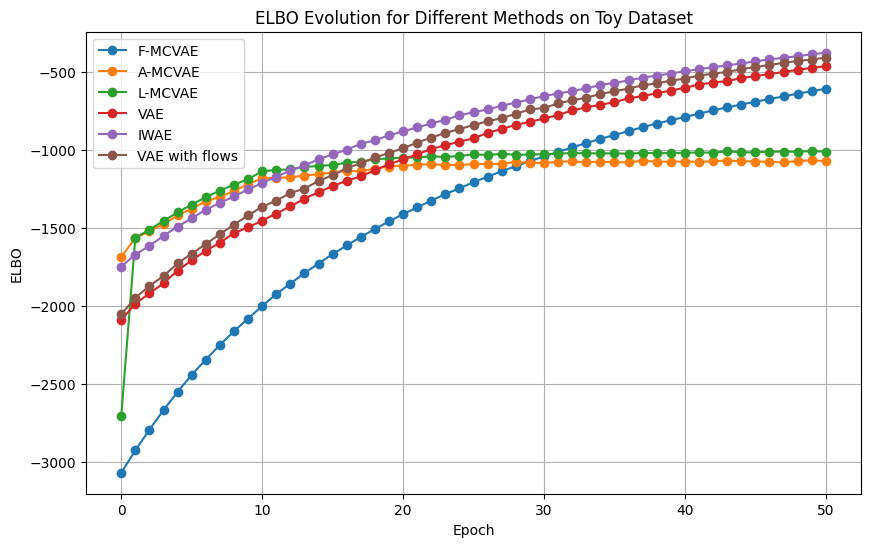

In [5]:
plt.figure(figsize=(10, 6))
for model_name, elbo_curve in results.items():
    plt.plot(elbo_curve, marker='o', linestyle='-', label=model_name)
plt.xlabel("Epoch")
plt.ylabel("ELBO")
plt.title("ELBO Evolution for Different Methods on Toy Dataset")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
results['A-MCVAE']

[-1686.42529296875,
 -1567.517333984375,
 -1522.8367919921875,
 -1476.577880859375,
 -1421.2919921875,
 -1377.8233642578125,
 -1331.918701171875,
 -1302.59228515625,
 -1265.28369140625,
 -1220.628173828125,
 -1183.3526611328125,
 -1180.08251953125,
 -1177.3441162109375,
 -1166.1109619140625,
 -1156.8546142578125,
 -1146.431396484375,
 -1135.6337890625,
 -1138.3275146484375,
 -1120.589111328125,
 -1107.6949462890625,
 -1101.791015625,
 -1096.4542236328125,
 -1092.9599609375,
 -1098.5635986328125,
 -1097.097900390625,
 -1092.244140625,
 -1091.7701416015625,
 -1089.465576171875,
 -1080.177978515625,
 -1083.3153076171875,
 -1085.3121337890625,
 -1077.75439453125,
 -1074.3658447265625,
 -1080.8538818359375,
 -1076.464111328125,
 -1081.5042724609375,
 -1080.0887451171875,
 -1071.06201171875,
 -1077.12353515625,
 -1076.7884521484375,
 -1076.3031005859375,
 -1077.1173095703125,
 -1074.712646484375,
 -1069.3060302734375,
 -1073.991455078125,
 -1075.7442626953125,
 -1077.1650390625,
 -1081.87353